#### Imports

In [209]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [210]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
346,3769880107,Data Engineer,"University of California, Riverside",CA,En remoto,Jornada completa,Intermedio,L,74668.0
195,3762499594,Machine Learning Engineer,Russell Tobin,CA,Presencial,Contrato por obra,Intermedio,L,182400.0
538,3776488139,Data Scientist,Home Partners of America®,IL,En remoto,Jornada completa,Sin experiencia,L,96000.0
339,3769543502,Data Scientist,"Integrated Resources, Inc ( IRI )",IA,En remoto,Contrato por obra,Intermedio,L,149500.0
545,3776584104,Machine Learning Engineer,Actalent,MD,En remoto,Jornada completa,Intermedio,L,207125.0


In [211]:
linkedin.shape

(580, 9)

First we need to see which columns have null values.

In [212]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
remote_ratio        17
employment_type      0
experience_level     3
company_size         6
salary              72
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [213]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(72, 9)

In [214]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(508, 9)

Let's save this dataframe for sql queries.

In [215]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [216]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
remote_ratio        2
employment_type     0
experience_level    3
company_size        5
salary              0
dtype: int64

In [217]:
linkedin = linkedin[linkedin[['remote_ratio']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['experience_level']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['company_size']].notna().any(axis=1)]
linkedin.shape

(499, 9)

##### Function to clean both datasets

In [218]:
def prepare_dataset(dframe):
    df = dframe.copy()
    # df = df.drop(columns=['company_name', 'company_state'])
    df = df[df[['remote_ratio']].notna().any(axis=1)]
    df = df[df[['experience_level']].notna().any(axis=1)]
    df = df[df[['company_size']].notna().any(axis=1)]
    return df

In [219]:
prepared_to_predict = prepare_dataset(to_predict)
prepared_to_predict.shape

(56, 9)

    Column 'job_title'

Classificating the job_title category with numbers.

In [220]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,195115.090909
8,Machine Learning Engineer,176279.583333
9,Research Engineer,176125.000000
1,BI Analyst,155742.333333
6,Data Scientist,139677.333333
5,Data Engineer,131093.882353
4,Data Analyst,112255.272727
0,AI Engineer,96454.166667
3,Business Analyst,96250.000000
2,BI Engineer,75000.000000


    Column 'remote_ratio'

In [221]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     195
Híbrido       176
Presencial    128
Name: count, dtype: int64

    Column 'employment_type'

In [222]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     369
Contrato por obra    100
Prácticas             30
Name: count, dtype: int64

    Column 'experience_level'

In [223]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 254
Sin experiencia            133
Algo de responsabilidad     48
Prácticas                   45
Director                    17
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [224]:
linkedin['company_size'].value_counts()

company_size
L    314
M    166
S     19
Name: count, dtype: int64

#### Cleaning function

In [225]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    oneonehotencoder = ps.OneHotEncoder()
    df[['Jornada completa', 'Contrato por obra', 'Prácticas']] = oneonehotencoder.fit_transform(df["employment_type"].values.reshape(-1, 1)).toarray()

    # 4. experience_level
    experience_categories = {
        'Director': 3,
        'Ejecutivo': 3,
        'Algo de responsabilidad': 2,
        'Intermedio': 2,
        'Sin experiencia': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df

In [226]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
10,3635061497,9,Scale AI,CA,50,Jornada completa,1,L,307710.0,0.0,1.0,0.0,1.0,0.0,0.0
375,3770505264,4,SBS Creatix,MO,50,Jornada completa,2,M,135000.0,0.0,1.0,0.0,0.0,1.0,0.0
534,3776484333,5,Dice,OH,50,Prácticas,0,L,45000.0,0.0,0.0,1.0,1.0,0.0,0.0
13,3645971561,5,ISmile Technologies,USA,50,Jornada completa,1,M,307710.0,0.0,1.0,0.0,0.0,1.0,0.0
408,3772218297,9,AllSTEM Connections,CA,0,Contrato por obra,1,L,108480.0,1.0,0.0,0.0,1.0,0.0,0.0


In [227]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
150,3759515210,5,People Tech Group Inc,MI,0,Prácticas,0,L,NaN,0.0,0.0,1.0,1.0,0.0,0.0


In [228]:
prepared_to_predict.isna().sum()

job_id                0
job_title             0
company_name          0
company_state         0
remote_ratio          0
employment_type       0
experience_level      0
company_size          0
salary               56
Jornada completa      0
Contrato por obra     0
Prácticas             0
L                     0
M                     0
S                     0
dtype: int64

In [229]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

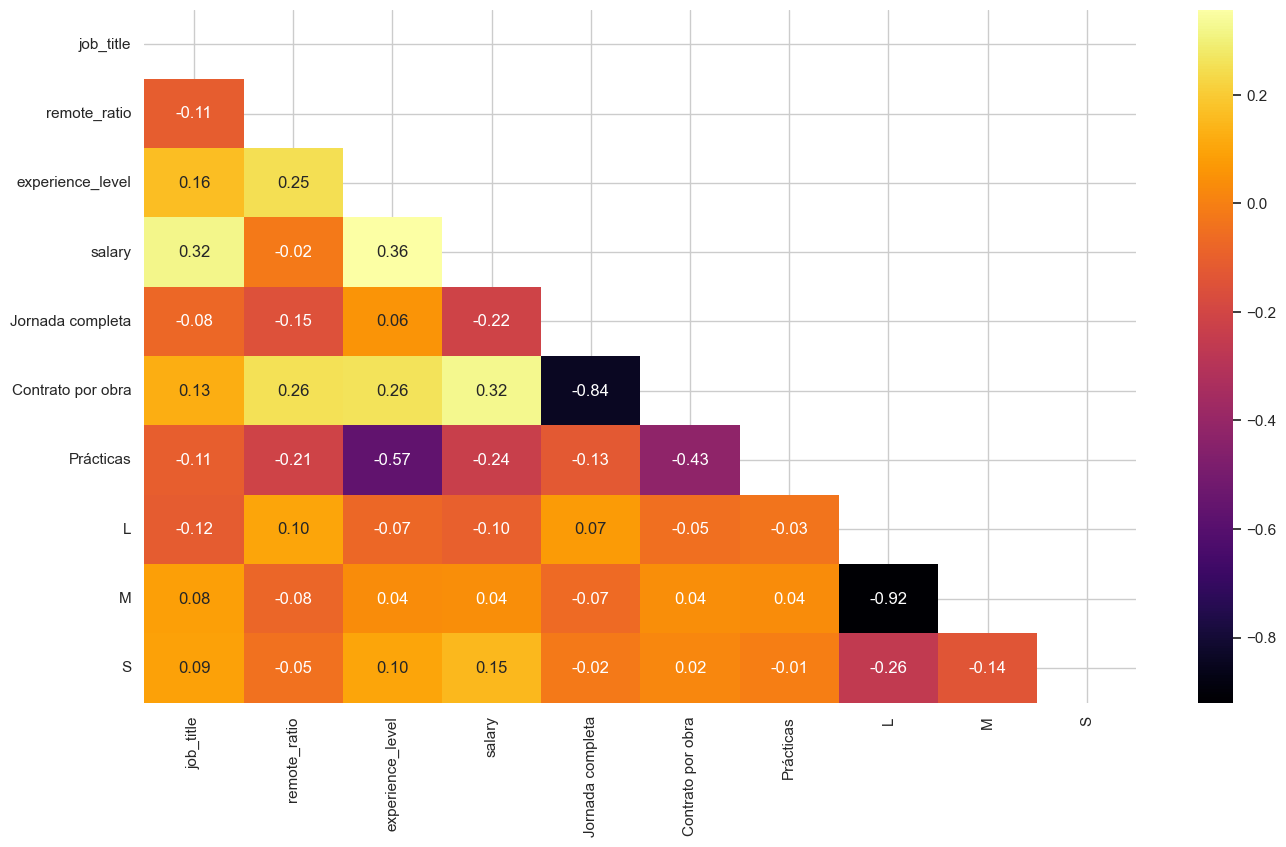

In [230]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [279]:
# X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary', 'min_salary', 'max_salary'])
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [233]:
X_train.shape

(374, 10)

    LinearRegression

In [234]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [235]:
y_pred = regressor.predict(X_test)

In [236]:
metrics.r2_score(y_test, y_pred)

0.3275572330027685

    DecisionTreeRegressor

In [237]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [238]:
y_pred = regressor.predict(X_test)

In [239]:
metrics.r2_score(y_test, y_pred)

0.3105492379160346

    KNeighborsRegressor

In [240]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [241]:
y_pred = regressor.predict(X_test)

In [242]:
metrics.r2_score(y_test, y_pred)

0.5223454800449341

    GradientBoostingRegressor

In [265]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [260]:
y_pred = regressor.predict(X_test)

In [262]:
r2_grad = metrics.r2_score(y_test, y_pred)
r2_grad

0.8219972580147646

    Code to save the model

In [263]:
import pickle

# model_file = f'../models/GradientBoostingRegressor_r2_{r2_grad}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [280]:
model_file = '../models/GradientBoostingRegressor_r2_0.8219972580147646.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.8496139973806547

    RandomForestRegressor

In [246]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [247]:
y_pred = regressor.predict(X_test)

In [248]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.7660285499769945

    Code to save the model

In [258]:
import pickle

model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
with open(model_file, 'wb') as f:
    pickle.dump(regressor, f)

In [281]:
model_file = '../models/RandomForestRegressor_r2_0.645222589224115.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.9131673022123568

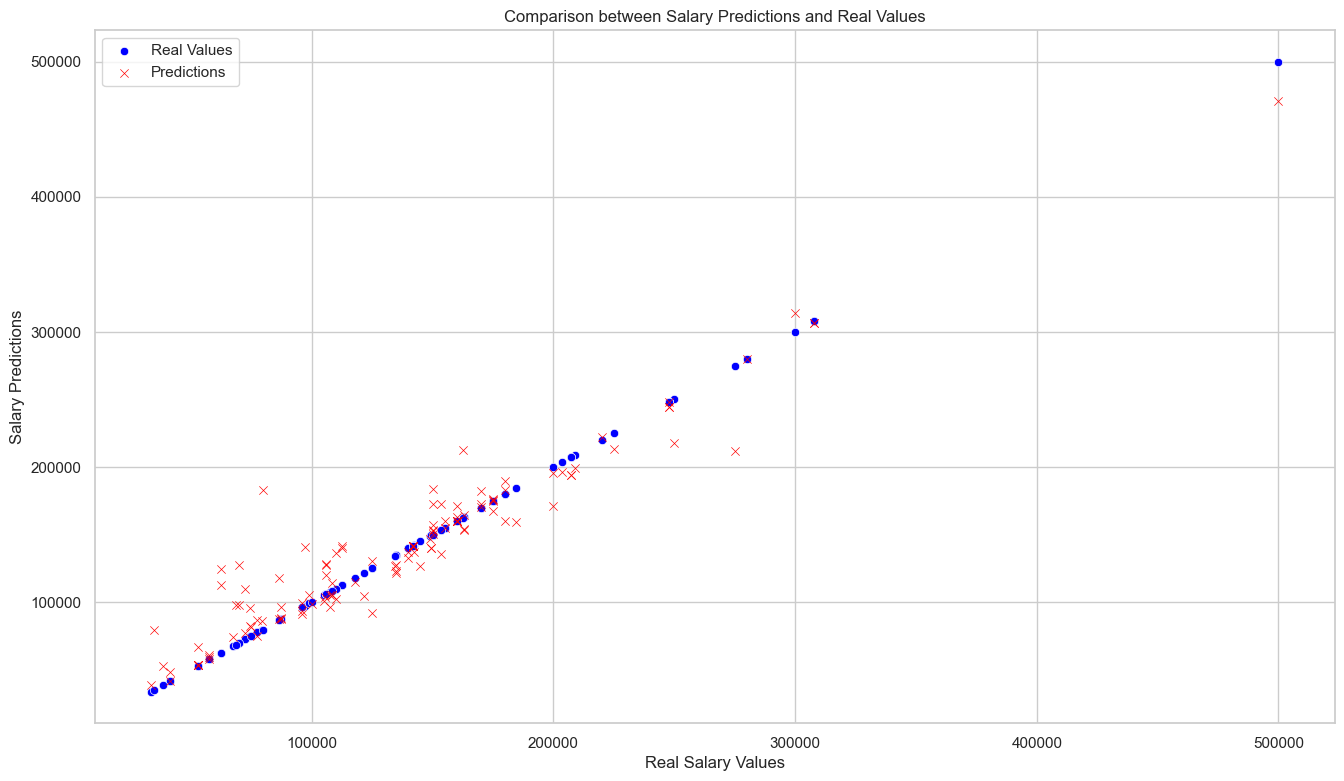

In [282]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

#### TESTS with X_test

In [252]:
X_test_copy = X_test.copy()
X_test_copy['pred_salary'] = y_pred
X_test_copy['salary'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S,pred_salary,salary
19,3680312613,9,0,2,0.0,1.0,0.0,1.0,0.0,0.0,138450.00,125000.0
225,3764401764,4,0,1,0.0,1.0,0.0,0.0,1.0,0.0,99767.60,105000.0
29,3700083571,6,50,3,0.0,1.0,0.0,0.0,1.0,0.0,244000.00,220000.0
228,3764639688,4,0,2,1.0,0.0,0.0,1.0,0.0,0.0,88134.16,66240.0
96,3752871763,9,100,2,1.0,0.0,0.0,1.0,0.0,0.0,131864.78,108480.0


    Saving X_test and prediction to see accuracy in tableau

In [253]:
X_test_copy.to_csv('../data/tableau_csv/X_test.csv')

#### Prediction for those with null salary

In [254]:
prediction = regressor.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [255]:
to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
99,3753408170,Deep Learning Engineer,NVIDIA,CA,Híbrido,Prácticas,Prácticas,L,NaN


In [256]:
prepared_to_predict['salary'] = prediction # Adding the predicted price
prepared_to_predict.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
235,3764783040,5,MindPal,AZ,0,Prácticas,0,M,87240.60,0.0,0.0,1.0,0.0,1.0,0.0
101,3755005401,5,Get It Recruit - Real Estate,VA,50,Prácticas,0,S,83246.00,0.0,0.0,1.0,0.0,0.0,1.0
498,3775558041,4,Fountain,USA,100,Media jornada,1,L,118204.74,0.0,1.0,0.0,1.0,0.0,0.0
150,3759515210,5,People Tech Group Inc,MI,0,Prácticas,0,L,94171.40,0.0,0.0,1.0,1.0,0.0,0.0
105,3755116125,6,INSIGHT2PROFIT,IL,50,Prácticas,0,L,86035.20,0.0,0.0,1.0,1.0,0.0,0.0


In [257]:
prepared_to_predict.to_csv('../data/linkedin_predicted_sql.csv', index=False)